# import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install xgboost
! pip install chinesecalendar

In [196]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns    
from statsmodels.graphics.tsaplots import plot_acf  
from statsmodels.tsa.stattools import adfuller as ADF 
from statsmodels.graphics.tsaplots import plot_pacf   
from statsmodels.stats.diagnostic import acorr_ljungbox    
from statsmodels.tsa.arima_model import ARIMA

import h5py

import xgboost 
from xgboost.sklearn import XGBRegressor

from chinese_calendar import is_workday, is_holiday
import datetime

# Load data

In [262]:
train = pd.read_csv("/content/drive/My Drive/MSBD5001/personal_proj/data/train.csv", parse_dates=['date'])
test =pd.read_csv("/content/drive/My Drive/MSBD5001/personal_proj/data/test.csv", parse_dates=['date'])
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      14006 non-null  int64         
 1   date    14006 non-null  datetime64[ns]
 2   speed   14006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 328.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      3504 non-null   int64         
 1   date    3504 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 54.9 KB


#### Date Extrations

In [263]:
hongkong_holiday = {datetime.date(2017, 1, 2),datetime.date(2017, 1, 28),datetime.date(2017, 1, 30),datetime.date(2017, 1, 31)\
          ,datetime.date(2017, 4, 4),datetime.date(2017, 4, 14),datetime.date(2017, 4, 15),datetime.date(2017, 4, 17)\
          ,datetime.date(2017, 5, 1),datetime.date(2017, 5, 3),datetime.date(2017, 5, 30),datetime.date(2017, 7, 1)\
          ,datetime.date(2017, 10, 2),datetime.date(2017, 10, 5),datetime.date(2017, 10, 28),datetime.date(2017, 12, 25)\
          ,datetime.date(2017, 12, 26),datetime.date(2018, 1, 1),datetime.date(2018, 2, 16),datetime.date(2018, 2, 17)\
          ,datetime.date(2018, 2, 19),datetime.date(2018, 3, 30),datetime.date(2018, 3, 31),datetime.date(2018, 4, 2)\
          ,datetime.date(2018, 4, 5),datetime.date(2018, 5, 1),datetime.date(2018, 5, 22),datetime.date(2018, 6, 18)\
          ,datetime.date(2018, 7, 2),datetime.date(2018, 9, 25),datetime.date(2018, 10, 1),datetime.date(2018, 10, 17)\
          ,datetime.date(2018, 12, 25),datetime.date(2018, 12, 26)}

In [264]:
#function that extrats year and month to creath columns in dateframe
def extract_date(df, column):
  '''input: df takes dataframe and column takes string'''
  df[column+'_year'] = df[column].apply(lambda x: x.year)
  df[column+'_month'] = df[column].apply(lambda x: x.month)
  df[column+'_day'] = df[column].apply(lambda x: x.day)
  df[column+'_hour'] = df[column].apply(lambda x: x.hour)
  df['is_holiday'] = df[column].apply(lambda x: 1 if is_holiday(x) else 0)
  df['Mon'] = df[column].apply(lambda x: 1 if x.weekday()==0 else 0)
  df['Tue'] = df[column].apply(lambda x: 1 if x.weekday()==1 else 0)
  df['Wed'] = df[column].apply(lambda x: 1 if x.weekday()==2 else 0)
  df['Thur'] = df[column].apply(lambda x: 1 if x.weekday()==3 else 0)
  df['Fri'] = df[column].apply(lambda x: 1 if x.weekday()==4 else 0)
  df['Sat'] = df[column].apply(lambda x: 1 if x.weekday()==5 else 0)
  df['Sun'] = df[column].apply(lambda x: 1 if x.weekday()==6 else 0)
  df['Jan'] = df[column].apply(lambda x: 1 if x.month==1 else 0)
  df['Feb'] = df[column].apply(lambda x: 1 if x.month==2 else 0)
  df['Mar'] = df[column].apply(lambda x: 1 if x.month==3 else 0)
  df['Apr'] = df[column].apply(lambda x: 1 if x.month==4 else 0)
  df['May'] = df[column].apply(lambda x: 1 if x.month==5 else 0)
  df['Jun'] = df[column].apply(lambda x: 1 if x.month==6 else 0)
  df['Jul'] = df[column].apply(lambda x: 1 if x.month==7 else 0)
  df['Aug'] = df[column].apply(lambda x: 1 if x.month==8 else 0)
  df['Sept'] = df[column].apply(lambda x: 1 if x.month==9 else 0)
  df['Oct'] = df[column].apply(lambda x: 1 if x.month==10 else 0)
  df['Nov'] = df[column].apply(lambda x: 1 if x.month==11 else 0)
  df['Dec'] = df[column].apply(lambda x: 1 if x.month==12 else 0)
  df['temp_diff'] = df[column].apply(lambda x: 2.25 if x.month in{1} else(1.25 if x.month in{9} else(0.75 if x.month in{4,6,8,10} \
                           else(0.25 if x.month in{2,3,5,11} else -0.25))))
  df['weekend'] = df[column].apply(lambda x: 1 if (x.weekday()==5)|(x.weekday()==6) else 0)
  df['day'] = df[column].apply(lambda x: x.weekday())
  df['season'] = df[column].apply(lambda x: 0 if x.month in{11,12,1,2} else(1 if x.month in{3,4} else(2 if x.month in{10} else 3)))
  df['Spring'] = df[column].apply(lambda x: 1 if x.month in {3,4} else 0)
  df['Summer'] = df[column].apply(lambda x: 1 if x.month in {5,6,7,8,9} else 0)
  df['Autumn'] = df[column].apply(lambda x: 1 if x.month in {10} else 0)
  df['Winter'] = df[column].apply(lambda x: 1 if x.month in {11,12,1,2} else 0)
  df['HK_holiday'] = df[column].apply(lambda x: 1 if (x.date() in hongkong_holiday)|(x.weekday()==6) else 0)
  df['student_holiday'] = df[column].apply(lambda x: 1 if x.month in [1,6,7,8] else 0)
  df['rush hour'] = df[column].apply(lambda x: 1 if (x.hour in [7,8,9,18,19,20])&(x.weekday()!=6) else 0)

In [265]:
extract_date(train, 'date')
extract_date(test, 'date')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               14006 non-null  int64         
 1   date             14006 non-null  datetime64[ns]
 2   speed            14006 non-null  float64       
 3   date_year        14006 non-null  int64         
 4   date_month       14006 non-null  int64         
 5   date_day         14006 non-null  int64         
 6   date_hour        14006 non-null  int64         
 7   is_holiday       14006 non-null  int64         
 8   Mon              14006 non-null  int64         
 9   Tue              14006 non-null  int64         
 10  Wed              14006 non-null  int64         
 11  Thur             14006 non-null  int64         
 12  Fri              14006 non-null  int64         
 13  Sat              14006 non-null  int64         
 14  Sun              14006 non-null  int64

,id,date,speed,date_year,date_month,date_day,date_hour,is_holiday,Mon,Tue,Wed,Thur,Fri,Sat,Sun,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,temp_diff,weekend,day,season,Spring,Summer,Autumn,Winter,HK_holiday,student_holiday,rush hour
0,0,2017-01-01 00:00:00,43.002930,2017,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2.25,1,6,0,0,0,0,1,1,1,0
1,1,2017-01-01 01:00:00,46.118696,2017,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2.25,1,6,0,0,0,0,1,1,1,0
2,2,2017-01-01 02:00:00,44.294158,2017,1,1,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2.25,1,6,0,0,0,0,1,1,1,0
3,3,2017-01-01 03:00:00,41.067468,2017,1,1,3,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2.25,1,6,0,0,0,0,1,1,1,0
4,4,2017-01-01 04:00:00,46.448653,2017,1,1,4,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2.25,1,6,0,0,0,0,1,1,1,0


In [238]:
add1 = {'date_year':[2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018],
       'date_month':[1,2,3,4,5,6,7,8,9,10,11,12,1,2,3,4,5,6,7,8,9,10,11,12],
       'rain':[28.8,52.9,41.3,82.9,326.5,229.3,108,428.5,313.7,23.5,23.5,23.5,65.9,4.8,26.1,50.3,65,484,208.1,492.5,300.8,31.5,56.1,16.8]}

df_add1 = DataFrame(add1)
df_add1
train_1 = train.merge(df_add1, on=['date_month','date_year'],how='outer')
test_1 = test.merge(df_add1, on=['date_month','date_year'],how='outer')

In [266]:
train.set_index('date', inplace = True)
test.set_index('date', inplace = True)

# Time Series Aggregation

In [ ]:
df_all= train.resample("H").asfreq()#.reset_index()
# df.resample('M').mean()
df_all['2017-01-02']

,id,speed,date_year,date_month,date_day,date_hour,is_holiday,Mon,Tue,Wed,Thur,Fri,Sat,Sun,Spring,Summer,Autumn,Winter,HK_holiday
date,,,,,,,,,,,,,,,,,,,
2017-01-02 00:00:00,735.0,49.026531,2017.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2017-01-02 01:00:00,736.0,47.431439,2017.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2017-01-02 02:00:00,737.0,46.479751,2017.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2017-01-02 03:00:00,738.0,47.432811,2017.0,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2017-01-02 04:00:00,739.0,46.714065,2017.0,1.0,2.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2017-01-02 05:00:00,740.0,44.394372,2017.0,1.0,2.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2017-01-02 06:00:00,741.0,43.218248,2017.0,1.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2017-01-02 07:00:00,742.0,40.964502,2017.0,1.0,2.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2017-01-02 08:00:00,743.0,24.217853,2017.0,1.0,2.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
extract_date(df_all, 'date')
na_num_2018 = df_all[df_all['date_year']==2018].isna().sum()
na_num_2017 = df_all[df_all['date_year']==2017].isna().sum()
print(na_num_2017,na_num_2018)

date           0
id            10
speed         10
date_year      0
date_month     0
date_day       0
date_hour      0
dtype: int64 date             0
id            3501
speed         3501
date_year        0
date_month       0
date_day         0
date_hour        0
dtype: int64


In [ ]:
df_all.set_index('date', inplace = True)

### Filling in Missing Data

In [ ]:
# fill the date with the lase known value
#df.resample("D").ffill().head()
#df.resample("D").bfill().head[6]；

### Date Indexing

In [ ]:
df_all['2017/01/01 00':'2017/03/04 01']

,id,speed,date_year,date_month,date_day,date_hour
date,,,,,,
2017-01-01 00:00:00,0.0,43.002930,2017,1,1,0
2017-01-01 01:00:00,1.0,46.118696,2017,1,1,1
2017-01-01 02:00:00,2.0,44.294158,2017,1,1,2
2017-01-01 03:00:00,3.0,41.067468,2017,1,1,3
2017-01-01 04:00:00,4.0,46.448653,2017,1,1,4
...,...,...,...,...,...,...
2017-03-03 21:00:00,1476.0,48.202270,2017,3,3,21
2017-03-03 22:00:00,1477.0,37.611800,2017,3,3,22
2017-03-03 23:00:00,1478.0,41.472712,2017,3,3,23


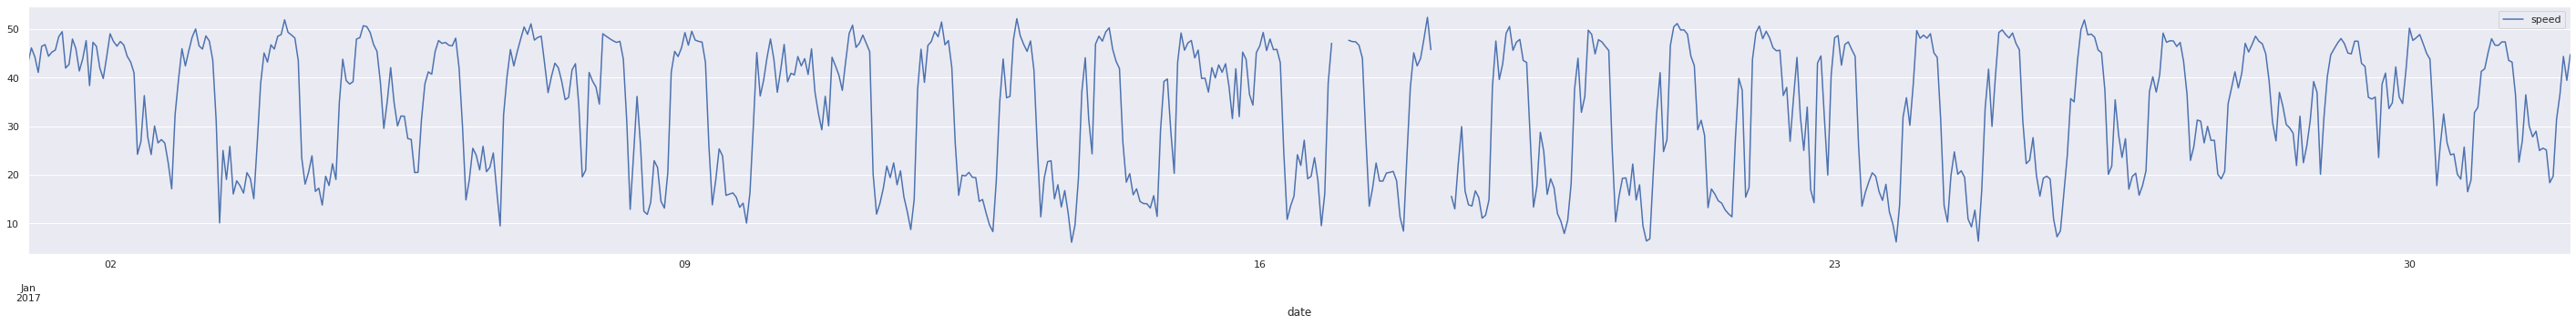

In [ ]:
sns.set(color_codes=True) #seaborn设置背景
df_all['2017/01'].plot(y="speed",figsize=(50,5))

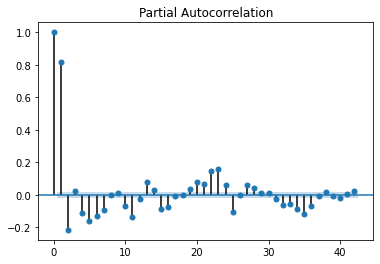

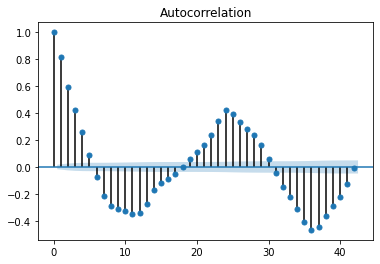

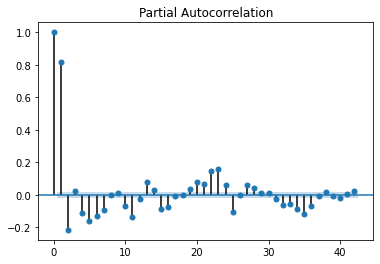

In [ ]:
plot_acf(df['speed'])
plot_pacf(df['speed'])

In [ ]:
print(u'原始序列的ADF检验结果为：', ADF(df['speed']))

原始序列的ADF检验结果为： (-18.98624223092823, 0.0, 42, 13963, {'1%': -3.430818416714503, '5%': -2.8617470187950538, '10%': -2.5668801913037695}, 93430.41511836687)


In [ ]:
df_0_speed = df[df['date_hour']==0]['speed']

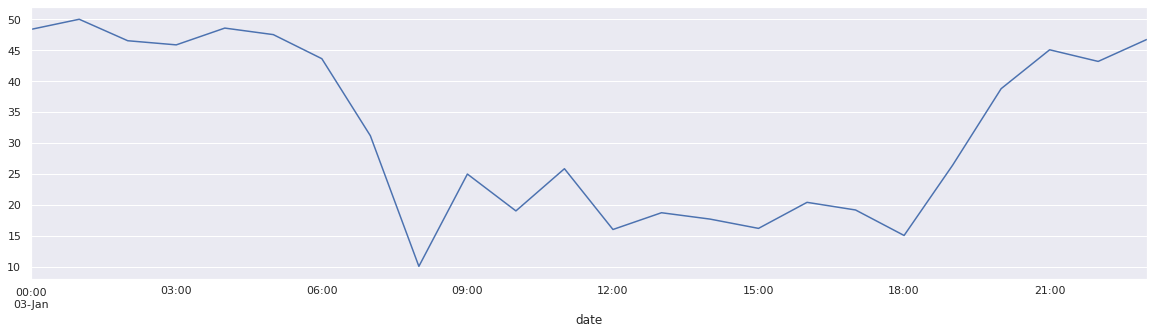

In [ ]:
df['2017/01/03']['speed'].plot(figsize=(20,5))

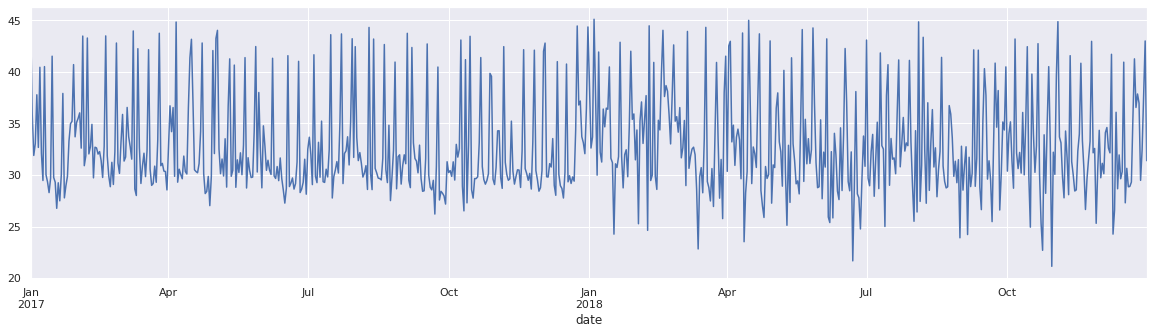

# train by day

In [ ]:
df_all= train.resample("H").asfreq()
df_all

,id,speed,date_year,date_month,date_day,date_hour,is_holiday,Mon,Tue,Wed,Thur,Fri,Sat,Sun,Spring,Summer,Autumn,Winter,HK_holiday
date,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,43.002930,2017.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2017-01-01 01:00:00,1.0,46.118696,2017.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2017-01-01 02:00:00,2.0,44.294158,2017.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2017-01-01 03:00:00,3.0,41.067468,2017.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2017-01-01 04:00:00,4.0,46.448653,2017.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 16:00:00,14003.0,12.501851,2018.0,12.0,31.0,16.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-12-31 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31 18:00:00,14004.0,15.979319,2018.0,12.0,31.0,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [186]:
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import numpy as np
from sklearn.utils import shuffle

In [311]:
X = train.drop(columns=['speed','id'])
y = train['speed']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.0001, random_state=42)
_, X_validation2, _, y_validation2 = train_test_split(X, y, test_size=0.25, random_state=42)

In [313]:
X_test = test.drop(columns=['id'])

In [314]:
print(len(X_validation))

2


In [296]:
# LGBMRegessor
model1 = lgb.LGBMRegressor(objective='regression', n_estimators=20)
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5,],
    'n_estimators': [50, 100, 200, 500],
}
# model1.fit(X_train,y_train)
lgbm_grid2 = GridSearchCV(model1, params, cv = 5, n_jobs = 5, verbose=True)
lgbm_grid2.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed: 11.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=20, n_jobs=-1, num_leaves=31,
                                     objective='regression', random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.03, 0.003],
                         'max_depth': [-1, 3, 5],
                         'n_estimators': [50, 100, 200, 500],
  

In [298]:
y_pred = lgbm_grid2.predict(X_validation2)
mean_squared_error(y_validation2, y_pred) #13.455696955939484

6.242939980837014

In [315]:
# XGBoost
xgb = XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
          'objective':['reg:linear'],
          'learning_rate': [0.1, 0.05, .007], #so called `eta` value
          'max_depth': [3, 5, 6, 7],
          'min_child_weight': [4],
          'silent': [1],
          'subsample': [0.7],
          'colsample_bytree': [0.7],
          'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb, parameters, cv = 5, n_jobs = 5, verbose=True, scoring='neg_mean_squared_error')

xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:  6.4min finished


-16.358965684291196
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [316]:
y_pred = xgb_grid.predict(X_validation2)
mean_squared_error(y_validation2, y_pred) #13.827619828967968

5.925603342391983

In [ ]:
#

In [321]:
y_final = lgbm_grid2.predict(X_test)
y_final

array([46.9370876 , 46.90056751, 39.7890183 , ..., 45.65131711,
       41.18255916, 43.9458813 ])

In [322]:
from pandas.core.frame import DataFrame
submit = {"speed": y_final}
submit_data = DataFrame(submit)
submit_data["speed"].to_list()

[46.937087596146554,
 46.90056750859448,
 39.789018302600724,
 30.20123430932168,
 37.204346147782616,
 27.059263013840656,
 22.523644353313475,
 49.53133745231193,
 48.63122328503144,
 34.049103296950236,
 27.913804243266526,
 24.480947885801758,
 22.907629352566136,
 21.606730264856534,
 25.644909302022096,
 41.09001166250129,
 44.112263408895245,
 46.91393652392682,
 48.23369311935985,
 49.044733349463705,
 47.68643418707844,
 45.6510771879237,
 18.535524017342542,
 25.047918113788114,
 25.41046016371699,
 19.761856541712955,
 20.298508188385224,
 18.83313546693877,
 17.959972939698613,
 13.603917125797834,
 24.18034835289914,
 46.017585348074626,
 48.27577311662287,
 29.957798463141724,
 23.886799331243264,
 22.75415374060709,
 21.060267542703595,
 20.50576121896083,
 40.696661242889064,
 36.19424307130333,
 39.56432653707219,
 46.941550208624754,
 47.736200549775724,
 43.274369132863114,
 19.621785563194983,
 18.745718341235154,
 18.896229162827613,
 13.056102240956717,
 40.195541

In [320]:
submit_data.to_csv("/content/drive/MyDrive/MSBD5001/personal_proj/data/results/final_10.csv", index_label="id")

### memo

In [ ]:
date = datetime.date(2020, 12, 5)
b = datetime.datetime(2020,12,2,5,22)
label = is_holiday(date)
print(label, date.weekday())
print(type(date.weekday()))
print(date.month in {1,3})
print(date in {datetime.date(2020, 12, 6),datetime.date(2020, 12, 8)})
print(b.date())
print(date.weekday())


True 5
<class 'int'>
False
False
2020-12-02
5


In [ ]:
len(y_final)

3504

In [ ]:
test.count()

id            3504
date_year     3504
date_month    3504
date_day      3504
date_hour     3504
is_holiday    3504
dtype: int64